
## Analytic Solutions Convergence Tests

This notebook runs series of simulations across different resolutions to extract error convergence information. Analytic Stokes flow solutions are used as a basis for error estimation. 


In [45]:
from collections import OrderedDict as OD

picklefiles=["Results_Weak_V210_noadvdiffnoswarmadv_DIM_3_BASE_32_ORDER_1_TOL_1e-7_PENALTY_-1._IO_0_MODEL_SolDB3d_Magnus/Errors.pickle",
    "Results_Weak_V210_retest_DIM_3_BASE_16_ORDER_2_TOL_1e-11_PENALTY_-1._IO_0_MODEL_SolDB3d_Magnus/Errors.pickle",
            ]


In [46]:
import math
import numpy as np
import collections

### Now perform convergence rate tests 

In [47]:
velocity_key = "Velocity"
pressure_key = "Pressure"

In [48]:
soln_results = OD()
for pickle in picklefiles:
    with open(pickle,'rb') as f:
        import pickle
        soln_results.update(pickle.load(f))

In [49]:
resolutions_1 = set()
resolutions_2 = set()
solns         = set()
for item,value in soln_results.items():
    solns.add(item[0])
    if item[1] == 1:
        resolutions_1.update(value.keys())
    if item[1] == 2:
        resolutions_2.update(value.keys())

Rejecting SolDB3d fit = 2.125959866631254, expected = 1.


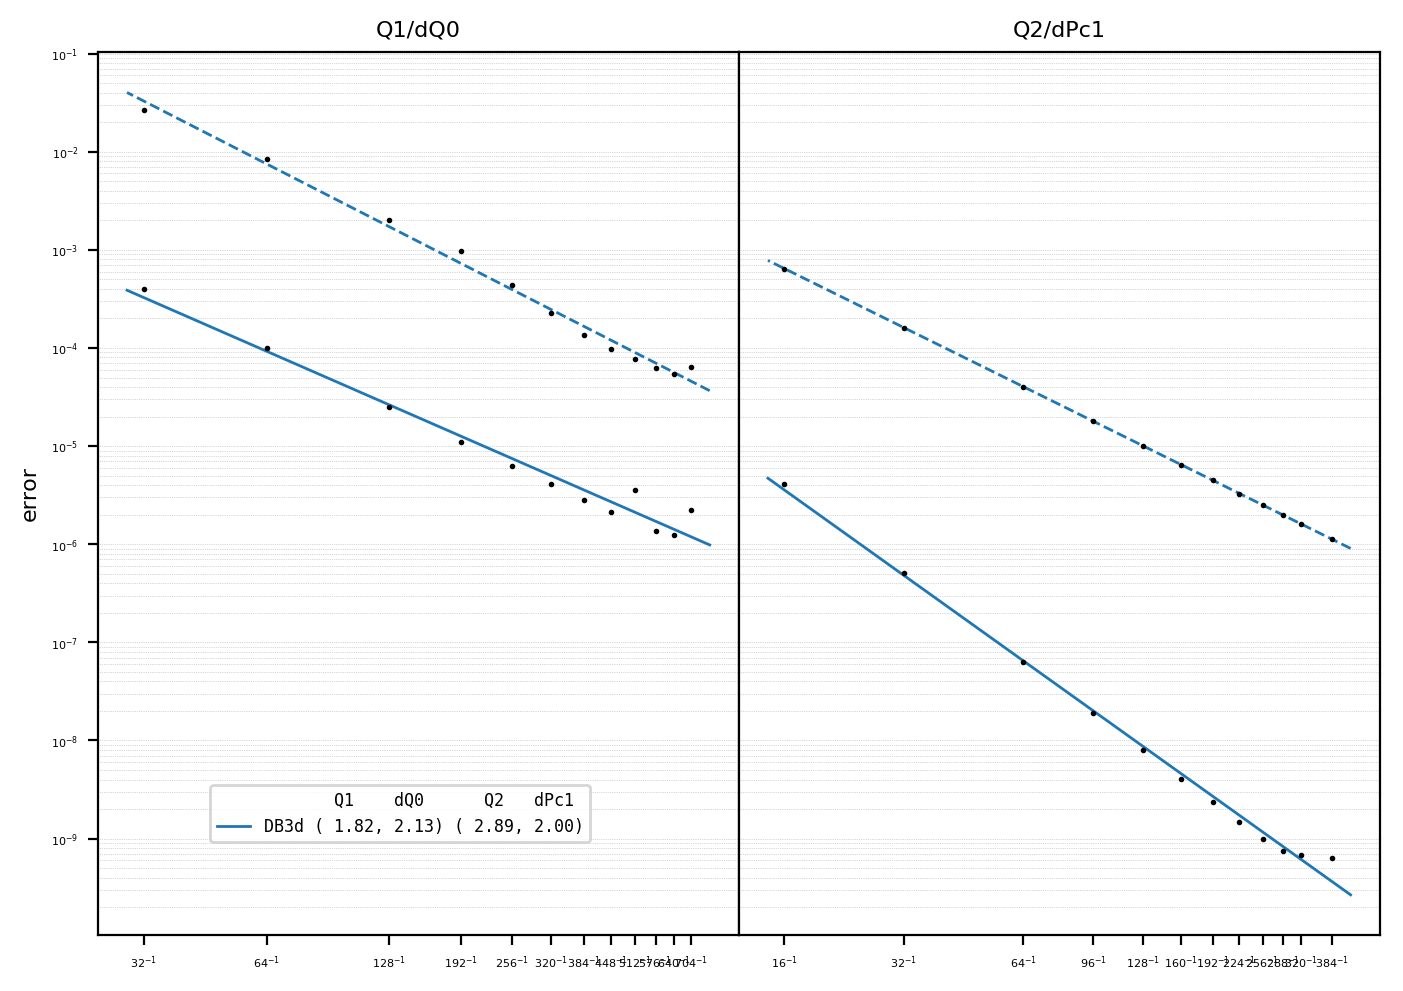

In [50]:
errtype = 0  # {0:"absolute", 1:"scaled absolute"}

fitfn = lambda x,a,b: a+b*x
def get_linear_fit(x,y):
    '''
    Returns best fit (a,b) for $ln(y)=a+b*ln(x)$ for provided
    set of points (x,y).
    '''
    import scipy.optimize
    return scipy.optimize.curve_fit(fitfn,  np.log(x),  np.log(y))

def get_fit_line(dx, fit):
    '''
    Evaluates fit across a set of points.
    '''
    dxmin = 0.9*dx.min()
    dxmax = 1.1*dx.max()
    xpts = np.linspace(dxmin,dxmax,20)
    ypts = np.exp(fitfn(np.log(xpts),*fit))
    return xpts, ypts

import matplotlib.pyplot as plt
fig = plt.figure(dpi=200, figsize=(8.27, 11.69/2.))
plt.subplots_adjust(wspace=.0)

# create some consistent colours & linestyles
from matplotlib.pyplot import cm
colours = cm.tab10(np.linspace(0,1,len(solns)))
scheme = {}
for it,sol in enumerate(solns):
    scheme[(sol,pressure_key)] = (colours[it],'--')
    scheme[(sol,velocity_key)] = (colours[it],'-')


def create_ax(pos, resolutions, title=None, other_ax=None):
    ax = plt.subplot(1,2,pos,xscale='log', yscale='log', sharey=other_ax)
    ax.set_title(title,fontsize=8)
    ax.invert_xaxis()
    ax.xaxis.set_ticks(np.reciprocal(resolutions, dtype='double'))
    ax.xaxis.set_ticklabels(["$ {{ {} }}^{{-1}}$".format(x) for x in resolutions])
    ax.grid(axis="y", which="both",linestyle=':',linewidth=0.25)
    ax.tick_params(axis='both', which='major', labelsize=8)
#         ax.set_xlabel("dx", fontsize=8)
    if not other_ax:
        ax.set_ylabel("error", fontsize=8)

    # disable minor ticks marks on axis
    for tic in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
        tic.tick1On = tic.tick2On = False
        tic.label1On = tic.label2On = False
    for tic in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
        tic.label.set_fontsize(4)
    # disable tick marks on rhs of other axis
    if other_ax:
        for tic in ax.yaxis.get_major_ticks():
            tic.tick1On = tic.tick2On = False
            tic.label1On = tic.label2On = False
    return ax

axes = {}
axes[1] = None
if len(resolutions_1)>0:
    axes[1] = create_ax(1, list(resolutions_1), title="Q1/dQ0")
if len(resolutions_2)>0:
    axes[2] = create_ax(2, list(resolutions_2), title="Q2/dPc1", other_ax=axes[1] )

# get fit results now so we can set plot labels
fits = {}
errs = {}
for key, err in soln_results.items():
    soln_name = key[0]

    fits[key], errs[key] = get_linear_fit(np.reciprocal(list(err.keys()),dtype='double'), [errval[errtype] for errval in err.values()] )

# keep set of lines for legend
lines = collections.OrderedDict()
for key, err in sorted(soln_results.items(), key=lambda x: x[0][0]):
    soln_name = key[0]
    order     = key[1]
    velpres   = key[2]
    ax        = axes[order]
    fit       = fits[key]
    fitdata   = get_fit_line(np.reciprocal(list(err.keys()),dtype='double'),fit)    

    expected_order = order if (key[2]==pressure_key) else order+1
    if not np.isclose(fit[1],expected_order,rtol=1.5e-1):
        print("Rejecting {} fit = {}, expected = {}.".format(soln_name,fit[1],expected_order))

    col,ls = scheme[(soln_name,velpres)]
    line = ax.plot(*fitdata, linewidth=1., color=col, linestyle=ls)
    if velpres == velocity_key:
        lines[soln_name] = line

    ax.plot(np.reciprocal(list(err.keys()),dtype='double'), [errval[errtype] for errval in err.values()], 'o', markersize=1., color='black')

lbls = []
lns = []
for soln_name in lines.keys():
    tit = ""
    lbl = "{}".format(soln_name[3:].ljust(4))
    if axes[1]:
        vel_1   = fits[(soln_name,1,velocity_key)][1]
        pre_1   = fits[(soln_name,1,pressure_key)][1]
        lbl += " ({: .2f},{: .2f})".format(vel_1,pre_1)
        tit += "Q1    dQ0  "
    if axes[2]:
        vel_2   = fits[(soln_name,2,velocity_key)][1]
        pre_2   = fits[(soln_name,2,pressure_key)][1]
        lbl += " ({: .2f},{: .2f})".format(vel_2,pre_2)
        tit += "    Q2   dPc1 "
    lbls.append(lbl)
    lns.append(lines[soln_name][0])

leg = fig.legend( lns, lbls, loc = (0.15, 0.15), prop={'family': 'monospace', 'size':6})
leg.set_title(tit, 
              {'family': 'monospace', 'size':6 })
leg._legend_box.align = "right"
fig.savefig("Analytic_Convergence_Graph.png")